**Remember `shift + enter` to run a cell**

#### Ion Trajectory Simulations in Quadrupole Mass Filter

#### Mass filters serve as indispensible analytical tools that stretch across disciplines
* Residual Gas Analyzers (RGAs)
* Underlying technology supporting triple quadrupole systems
  * Most sensitive mass spectrometers
* Front end separations and filters for additional high resolution systems

In [21]:
import scipy.special as sp
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import integrate
import scipy.constants as C

In [22]:
from matplotlib import animation, rc
#https://stackoverflow.com/questions/23074484/cannot-save-matplotlib-animation-with-ffmpeg
plt.rcParams['animation.ffmpeg_path'] = '/anaconda2/envs/p4env/bin/ffmpeg'
from IPython.display import HTML

In [23]:
#import seaborn as sns # use for fancy plots

### Adapted from the Jimenez Research Group: http://cires1.colorado.edu/jimenez-group/

In [24]:
e_C = 1.6e-19 # Unit charge in C
AMU_2_KG = 1.6603e-27 # Mass of an amu in kg
L_QUAD_m = 0.11 # Length of quadrupole in m0.11
FREQ_Hz = 2.26e6 # Frequency of the voltage on the quadrupole
R0_m = 0.0045 # Quadrupole rod diameter in mm
EZ_eV = 20 # Kinetic energy in the Z direction, eV
YES = 1 # Note this trick to make code more understandable
NO = 0

In [25]:
C.elementary_charge

1.6021766208e-19

In [26]:
np.pi

3.141592653589793

In [27]:
def Calc_Ion_Traj_Quad(ionMassAMU, U, V, nSteps = 100, freqHZ = 2.26E6, r0 = 0.0045, quadLength = 0.11, zKE = 20.0, verbose = False):
    '''
    ************ Calculate the trajectory of an ion *************************
    Following the Steel and Benchman (1998) J Chem Ed article
    ionMassAMU		// mass of the singly charged ion in amu
    Variable U, V
    Variable N_STEPS
    
    Variable IonMass_kg			// Ion mass in kg
    Variable a, q					// Quad parameters
    '''
    omegaRad = freqHZ * 2 * np.pi
    wTime = np.arange(nSteps)
    wPhi = np.zeros(nSteps)
    wX = np.zeros(nSteps)
    wY = np.zeros(nSteps)
    wZ = np.zeros(nSteps)
    wVx = np.zeros(nSteps)
    wVy = np.zeros(nSteps)

    
    ionMassKG = ionMassAMU * C.m_u
    a = 8 * C.elementary_charge * U / (r0**2 * ionMassKG * omegaRad**2)
    q = 4 * C.elementary_charge * V / (r0**2 * ionMassKG * omegaRad**2)
    
    wX[0] = 0.0007 
    wY[0] = 0.0007

    #Integration Loop
    
    vZ = np.sqrt(2 * C.elementary_charge * zKE / ionMassKG)
    if verbose:
        print(vZ)

    wTime = wTime/(nSteps - 1) * (quadLength / vZ)
    dt = wTime[1] - wTime[0]
    period = 1.0 / freqHZ
    if verbose:
        print(period/dt)
    
    wPhi = wTime * omegaRad / 2.0
    i = 0
    stableBool = True
    tUnstable = -1
    for i in range(nSteps-1):
        wX[i+1] = wX[i]+dt*wVx[i]
        wY[i+1] = wY[i]+dt*wVy[i]
        wZ[i+1] = wZ[i]+dt*vZ
        
        if((np.abs(wX[i+1])>r0) or (np.abs(wY[i+1])>r0)):
#             print(wX[i+1], wY[i+1])
            stableBool = False
            break #break #is this what we want to do?
            if(tUnstable == 0):
                tUnstable = i
        wVx[i+1] = wVx[i]+dt*(-2*C.elementary_charge*(U + V * np.cos(omegaRad * wTime[i])) * wX[i] / (ionMassKG*r0**2))
        wVy[i+1] = wVy[i]+dt*(2*C.elementary_charge*(U + V * np.cos(omegaRad * wTime[i])) * wY[i] / (ionMassKG*r0**2))
        
    if(tUnstable != 0):
        wX[tUnstable:nSteps-1] = np.nan
        wY[tUnstable:nSteps-1] = np.nan

    return wX, wY, wZ, wVx, wVy, wTime, stableBool


In [28]:
trajPnts = 500
wX, wY, wZ, wVx, wVy, wTime, stableBool = Calc_Ion_Traj_Quad(200,3,620,trajPnts, verbose = True)
for vec in [wX,wY,wZ]:
    vec*=1000.0#convert to mm
print(stableBool)

4392.84265385
8.81749189167
True


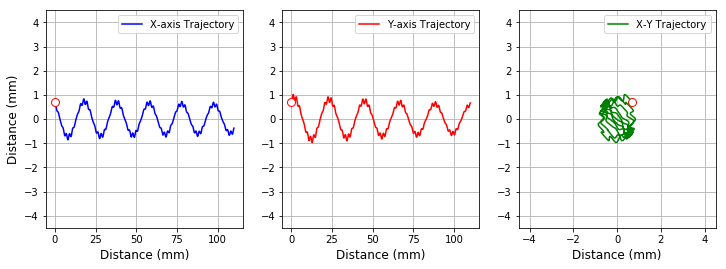

In [29]:
pntList = []
lineList = []

ms = 8

fig, axList = plt.subplots(ncols = 3, figsize = (12,4))
ax0 = axList[0]
ax1 = axList[1]
ax2 = axList[-1]

ax0.plot(wZ, wX, 'b', label = 'X-axis Trajectory')
p0, = ax0.plot(wZ[0], wX[0], 'ro', ms = ms, mfc = 'white')
pntList.append(p0)
lineList.append([wZ, wX])
ax0.set_ylim(-R0_m*1000, R0_m*1000)#constrain to radius of quads
ax0.set_ylabel("Distance (mm)", fontsize = 12)
ax0.set_xlabel("Distance (mm)", fontsize = 12)
ax0.grid()
ax0.legend()

ax1.plot(wZ, wY, 'r', label = 'Y-axis Trajectory')
p1, = ax1.plot(wZ[0], wY[0], 'ro', ms = ms, mfc = 'white')
pntList.append(p1)
lineList.append([wZ, wY])
ax1.set_ylim(-R0_m*1000, R0_m*1000)#constrain to radius of quads
ax1.set_xlabel("Distance (mm)", fontsize = 12)
ax1.grid()
ax1.legend()

ax2.plot(wX, wY, 'g', label = 'X-Y Trajectory')
p2, = ax2.plot(wX[0], wY[0], 'ro', ms = ms, mfc = 'white')
pntList.append(p2)
lineList.append([wX, wY])
ax2.grid()
ax2.set_ylim(-R0_m*1000, R0_m*1000)#constrain to radius of quads
ax2.set_xlim(-R0_m*1000, R0_m*1000)#constrain to radius of quads
ax2.set_xlabel("Distance (mm)", fontsize = 12)
ax2.legend()

In [30]:
def run(it):
#     print(it)
    for i, pnt in enumerate(pntList):
        x,y = lineList[i]
        pnt.set_data(x[it], y[it])
    return pntList

In [31]:
anim = animation.FuncAnimation(fig, run,
                               frames=trajPnts, interval=10, 
                               blit=True)

### The following call requires ffmpeg to run, however, the next call can work in cases where ffmpeg is not installed.

In [ ]:
HTML(anim.to_html5_video())# will not work without the proper movie writer backend.

In [ ]:
HTML(anim.to_jshtml()) #this call could take a couple of minutes

In [ ]:
saveBool = False
if saveBool:
    anim.save('quadSim.mp4')

### Generate the Countours for the Electric Fields

In [ ]:
def getPotential(x,y,numPnts,radius,U,V,freqHz,t):
    localPotential = (((x-numPnts/2+0.5)/numPnts*2*radius)**2 - ((y-numPnts/2+0.5)/numPnts*2*radius)**2) * (U+V*np.cos(2 * np.pi * freqHz * t))/radius**2
    return localPotential

In [ ]:
def getQuadField(U, V, t, radius = R0_m, freqHz = FREQ_Hz, numPnts = 100):
    
    potential = np.zeros((numPnts, numPnts))
    for i,m in enumerate(range(numPnts)):
        for j,n in enumerate(range(numPnts)):
            potential[i][j] = getPotential(i,j,numPnts,radius,U,V,freqHz,t)
            
    return potential

In [ ]:
potential = getQuadField(33,610,200)

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
pcMesh = plt.pcolormesh(potential, shading='gouraud', cmap=plt.cm.BuGn_r)
con = plt.contour(potential, 12, colors = ['w'])
ax.clabel(con, inline=1, fontsize=12, fmt = '%.1f')

In [ ]:
U_main = 33
V_main = 610
tVal = 200

In [ ]:
# https://stackoverflow.com/questions/49063430/matplotlib-how-to-animate-pcolormesh-with-large-data-set
fig, ax = plt.subplots(figsize = (12,8))

def animate(i):
    ax.cla()
    localPot = getQuadField(U_main, V_main, i)
    pc = ax.pcolormesh(localPot, shading='gouraud', cmap=plt.cm.BuGn_r)
    con = ax.contour(localPot, 12, colors = ['w'])
    ax.clabel(con, inline=1, fontsize=12, fmt = '%.1f')
    return pc,con,

# ax.axis([-9,30,-9,30])
im_ani = animation.FuncAnimation(fig, animate, frames=wTime, interval=1000, blit=False)

In [ ]:
HTML(im_ani.to_html5_video())#this call can take a while so relax, have a homebrew.

In [ ]:
HTML(im_ani.to_jshtml()) #this call could take a couple of minutes